Hands-on Code Implementation of the Chapter 04 of 'Build LLM From Scratch'.

In [1]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch
import torch.nn as nn
import sys
from pathlib import Path
import matplotlib.pyplot as plt

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.9.2
torch version: 2.4.0
tiktoken version: 0.7.0


In [56]:
#Loading the attention classes: 

sys.path.insert(0, 'D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch03\Attention_Implementation')
sys.path.insert(1, "D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch04\Transformer_Implementation")
#sys.path[0] = str(Path(sys.path[0]).parent)
from causal_multi_head_attention import MultiHead_Attention
from causal_attention import Causal_Attention
from self_attention import Self_Attention

from feedforward import FeedForwardBlock
from gelu import GELU
from layernorm import LayerNormalization
from transformer import TransformerBlock
from gpt2 import GPT2


In [3]:
#Checking the contents of the system path:
#sys.path

['D:\\LLM_Deeplearning.ai\\SEBASTIAN_RASCHKA\\LLMs-from-scratch-main\\LLMs-from-scratch-main\\ch03\\Attention_Implementation',
 'D:\\LLM_Deeplearning.ai\\SEBASTIAN_RASCHKA\\LLMs-from-scratch-main\\LLMs-from-scratch-main\\ch04\\Transformer_Implementation',
 'c:\\Users\\Public\\anaconda3\\envs\\torch-gpu-cuda12.5\\python311.zip',
 'c:\\Users\\Public\\anaconda3\\envs\\torch-gpu-cuda12.5\\DLLs',
 'c:\\Users\\Public\\anaconda3\\envs\\torch-gpu-cuda12.5\\Lib',
 'c:\\Users\\Public\\anaconda3\\envs\\torch-gpu-cuda12.5',
 '',
 'c:\\Users\\Public\\anaconda3\\envs\\torch-gpu-cuda12.5\\Lib\\site-packages',
 'c:\\Users\\Public\\anaconda3\\envs\\torch-gpu-cuda12.5\\Lib\\site-packages\\win32',
 'c:\\Users\\Public\\anaconda3\\envs\\torch-gpu-cuda12.5\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\Public\\anaconda3\\envs\\torch-gpu-cuda12.5\\Lib\\site-packages\\Pythonwin',
 'c:\\Users\\Public\\anaconda3\\envs\\torch-gpu-cuda12.5\\Lib\\site-packages\\setuptools\\_vendor']

### GPT Backbone:

In [4]:
#GPT Config:
GPT2_CONFIG = {
    'vocab_size':50257,
    'embedding_dimension':768,
    'num_heads':12,
    'context_length':1024,
    'dropout':0.1,
    'qkv_bias':False,
    'num_layers':12,
}

In [5]:
#Creating the backbone of the GPT Class:

class GPTDummyBackbone(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embedding = nn.Embedding(config['vocab_size'],config['embedding_dimension'])
        self.pos_embedding = nn.Embedding(config['context_length'],config['embedding_dimension'])
        self.token_dropout = nn.Dropout(config['dropout'])

        self.transformer_block = nn.Sequential(
            *[DummyTransformerBlock(config) for _ in range(config['num_layers'])]
        )

        self.final_layerNorm = DummyLayerNorm(config)

        self.final_projection = nn.Linear(config['embedding_dimension'],config['vocab_size'],bias=False)

    def forward(self,token_list):

        batch_size, context_length = token_list.shape

        #Get the embeddings for the list of tokens:
        token_embed = self.token_embedding(token_list)

        #Get the postional embeddings for the list of tokens:
        pos_embed = self.pos_embedding(torch.arange(context_length, device=token_list.device))

        #Final Embeddings:
        input = token_embed + pos_embed

        #Pass the input through the dropout layer:
        input = self.token_dropout(input)

        #Pass the dropped out input through the transformer blocks:
        input = self.transformer_block(input)

        #Pass the output through the final layer normalization block:
        input = self.final_layerNorm(input)

        #Pass the output through the final projection/linear layer:
        logits = self.final_projection(input)

        return logits

#Creating the backbone of the Transformer Class:
class DummyTransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

    def forward(self,input):
        return input
    
#Creating the backbone of the Layer Normalization Class:
class DummyLayerNorm(nn.Module):
    def __init__(self, config):
        super().__init__()

    def forward(self,input):
        return input


In [6]:
#Create the tokens:
def create_tokens(embedding_name,input):
    encoding = tiktoken.get_encoding(embedding_name)
    batch_inputs = []
    for i in range(len(input)):
        batch_inputs.append(torch.tensor(encoding.encode(input[i])))

    batch_inputs = torch.stack(batch_inputs,dim=0)
    return batch_inputs

In [7]:
input = ["Every effort moves you","Every day holds a"]
batch_tokens = create_tokens('gpt2',input)
print(batch_tokens)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [8]:
torch.manual_seed(123)
gpt = GPTDummyBackbone(GPT2_CONFIG)
logits = gpt(batch_tokens)
print(logits)
print('Output Shape: ', logits.shape)

tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
Output Shape:  torch.Size([2, 4, 50257])


### Submodule 1: Layer Normalization

In [53]:
def layer_normalization(inputs):
    print('Inputs: ', inputs)
    mean = inputs.mean(dim=-1, keepdim=True)
    var = inputs.var(dim=-1, keepdim=True)

    print('\nInitial Mean:\n ', mean)
    print('\nInitial Var: \n', var)
    eps = 1e-5
    scale = nn.Parameter(torch.ones(inputs.shape[-1]))
    shift = nn.Parameter(torch.zeros(inputs.shape[-1]))

    normalized_outputs = (inputs - mean) / torch.sqrt(var+eps)
    output_mean = normalized_outputs.mean(dim=-1, keepdim=True)
    output_var = normalized_outputs.var(dim=-1, keepdim=True)

    print('\nOutput Mean:\n ', output_mean)
    print('\nOutput Var:\n ', output_var)

    scaled_shifted_input = normalized_outputs * scale + shift

    return scaled_shifted_input

In [54]:
torch.set_printoptions(sci_mode=False)

inputs = torch.rand(3,5)

linear = nn.Linear(5,6,bias=False)
linear_inputs = linear(inputs)

outputs = layer_normalization(linear_inputs)
print('\nOutputs:\n ', outputs)

Inputs:  tensor([[ 0.3895, -0.2203, -0.2235, -0.1244,  0.6540, -0.4583],
        [ 0.6638, -0.7456, -0.1868, -0.1832,  0.4362, -0.6315],
        [ 0.3498, -0.0483, -0.1326, -0.1694,  0.1667, -0.6135]],
       grad_fn=<MmBackward0>)

Initial Mean:
  tensor([[ 0.0028],
        [-0.1079],
        [-0.0745]], grad_fn=<MeanBackward1>)

Initial Var: 
 tensor([[0.1807],
        [0.3168],
        [0.1084]], grad_fn=<VarBackward0>)

Output Mean:
  tensor([[    -0.0000],
        [     0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)

Output Var:
  tensor([[0.9999],
        [1.0000],
        [0.9999]], grad_fn=<VarBackward0>)

Outputs:
  tensor([[ 0.9096, -0.5249, -0.5326, -0.2993,  1.5319, -1.0848],
        [ 1.3708, -1.1329, -0.1403, -0.1338,  0.9665, -0.9303],
        [ 1.2891,  0.0798, -0.1764, -0.2882,  0.7328, -1.6371]],
       grad_fn=<AddBackward0>)


### Submodule 2: Activations

In [11]:
def activations(inputs,activation_type='relu'):
    print('Activation Type: ', activation_type)

    if activation_type == 'relu':
        relu = nn.ReLU()
        activation_outputs = relu(inputs)
    else:
        activation_outputs = 0.5 * inputs * ( 1 + torch.tanh((torch.sqrt(torch.tensor(2.0 /torch.pi)))
                                                             * 
                                                             (inputs + 0.044715 * torch.pow(inputs,3)) 
                                                             )
                                            )
    
    return activation_outputs

Activation Type:  gelu
Activation Type:  relu


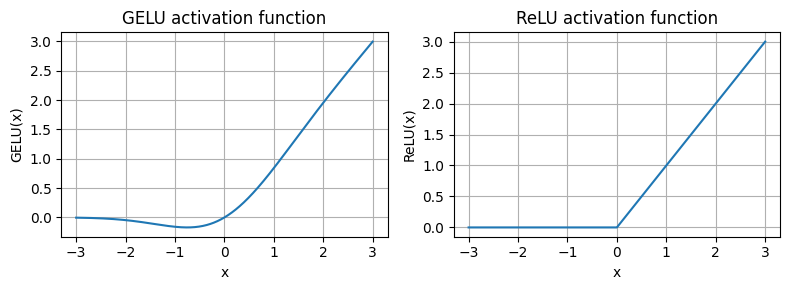

In [12]:
x = torch.linspace(-3, 3, 1000)

y_gelu = activations(x,'gelu')
y_relu = activations(x,'relu')

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

### Submodule 3: FeedForward Layers

In [20]:
feedforward = FeedForwardBlock(GPT2_CONFIG)
x = torch.rand(2, 3, 768) 
ff_outputs = feedforward(x)
print('Feed Forward Outputs:\n', ff_outputs)
print('Shape: ', ff_outputs.shape)

Feed Forward Outputs:
 tensor([[[-0.1093,  0.1036, -0.0993,  ...,  0.1544,  0.0850, -0.0392],
         [-0.0327,  0.0328, -0.0626,  ...,  0.0928,  0.0240,  0.0093],
         [-0.0621,  0.0158, -0.0885,  ...,  0.1898,  0.0158, -0.0376]],

        [[-0.0348, -0.0492,  0.0358,  ...,  0.2244,  0.1093, -0.0123],
         [-0.0472,  0.0981, -0.0688,  ...,  0.2097,  0.0349,  0.0657],
         [-0.1848,  0.0104,  0.0245,  ...,  0.2260,  0.0982, -0.0207]]],
       grad_fn=<ViewBackward0>)
Shape:  torch.Size([2, 3, 768])


### Submodule 4: Residuals

In [43]:
#Tutorial on the benefits of residual:
class DeepNetwork(nn.Module):
    def __init__(self,num_neurons,residual=False):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(num_neurons[0],num_neurons[1],GELU()),
            nn.Linear(num_neurons[1],num_neurons[2],GELU()),
            nn.Linear(num_neurons[2],num_neurons[3],GELU()),
            nn.Linear(num_neurons[3],num_neurons[4],GELU()),
            nn.Linear(num_neurons[4],num_neurons[5],GELU())
        ])
        self.residual = residual

    def forward(self,input):
        x = input
        for layer in self.layers:
            output = layer(x)
            if self.residual and output.shape == x.shape:
                x = output + x
            else:
                x = output
        
        return x
    
def compute_loss(model,inputs):
    y_pred = model(inputs)
    y_true = torch.tensor([[0.]])

    loss = nn.MSELoss()
    l = loss(y_pred,y_true)

    l.backward()

    for name,param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")


In [47]:
neurons = [3, 4, 5, 6, 7, 1]
sample_input = torch.tensor([[1., 0., -1., ]])
torch.manual_seed(123)
network = DeepNetwork(neurons, residual=False)
print("WITHOUT RESIDUAL:::")
print(compute_loss(network,sample_input))
print("WITH RESIDUAL:::")
network_residual = DeepNetwork(neurons,residual=True)
print(compute_loss(network_residual,sample_input))


WITHOUT RESIDUAL:::
layers.0.weight has gradient mean of 0.0008832925814203918
layers.1.weight has gradient mean of 0.001083269133232534
layers.2.weight has gradient mean of 0.004338949918746948
layers.3.weight has gradient mean of 0.004670488182455301
layers.4.weight has gradient mean of 0.030293656513094902
None
WITH RESIDUAL:::
layers.0.weight has gradient mean of 0.01008217316120863
layers.1.weight has gradient mean of 0.012564634904265404
layers.2.weight has gradient mean of 0.016338523477315903
layers.3.weight has gradient mean of 0.013615252450108528
layers.4.weight has gradient mean of 0.1283888965845108
None


### Main Module 1: Transformer Block

In [57]:
x = torch.rand(2, 4, 768)
transformer_block = TransformerBlock(GPT2_CONFIG)
output = transformer_block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


### Main Module 2: GPT Block

In [62]:
torch.manual_seed(123)
gpt2 = GPT2(GPT2_CONFIG)
gpt2_logits = gpt2(batch_tokens)
print('Shape of Custom GPT2\'s Input: ', batch_tokens.shape)
print('Shape of Custom GPT2\'s Output: ', gpt2_logits.shape)
print('Custom GPT2\'s logits::\n',gpt2_logits)

Shape of Custom GPT2's Input:  torch.Size([2, 4])
Shape of Custom GPT2's Output:  torch.Size([2, 4, 50257])
Custom GPT2's logits::
 tensor([[[ 0.1768, -0.8737,  0.3266,  ..., -0.3018, -1.1260,  0.2089],
         [ 0.1768, -0.8737,  0.3266,  ..., -0.3018, -1.1260,  0.2089],
         [ 0.1768, -0.8737,  0.3266,  ..., -0.3018, -1.1260,  0.2089],
         [ 0.1768, -0.8737,  0.3266,  ..., -0.3018, -1.1260,  0.2089]],

        [[ 0.1768, -0.8737,  0.3266,  ..., -0.3018, -1.1260,  0.2089],
         [ 0.1768, -0.8737,  0.3266,  ..., -0.3018, -1.1260,  0.2089],
         [ 0.1768, -0.8737,  0.3266,  ..., -0.3018, -1.1260,  0.2089],
         [ 0.1768, -0.8737,  0.3266,  ..., -0.3018, -1.1260,  0.2089]]],
       grad_fn=<UnsafeViewBackward0>)


In [63]:
#Calculate the number of parameters in Custom GPT2 Model:
def compute_model_params(model):
    num_params = 0
    for params in model.parameters():
        num_params = num_params + params.numel()
    return num_params

In [66]:
gpt2_small = compute_model_params(gpt2)
print(f'Custom GPT2 Small Total Params: {gpt2_small:,}')

Custom GPT2 Small Total Params: 163,009,536


In [70]:
print('Custom GPT2\'s Architecture: \n', gpt2)

Custom GPT2's Architecture: 
 GPT2(
  (token_embedding): Embedding(50257, 768)
  (pos_embedding): Embedding(1024, 768)
  (token_dropout): Dropout(p=0.1, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (attention_block): MultiHead_Attention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (final_projection): Linear(in_features=768, out_features=768, bias=True)
      )
      (layer_norm_attention): LayerNormalization()
      (layer_norm_feedforward): LayerNormalization()
      (dropout): Dropout(p=0.1, inplace=False)
      (feedForward): FeedForwardBlock(
        (block): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, b

In [77]:
print('Token Embedding Layer Output shape: ', gpt2.token_embedding.weight.shape)
print('Token Embedding Layer Total weights: ', gpt2.token_embedding.weight.numel())
print('Token Embedding Layer Total weights: ', gpt2.pos_embedding.weight.numel())
print('Final projection(linear) Layer Total weights: ', gpt2.final_projection.weight.numel())

print(f'Total GPT2\'s weights with weight sharing on final projection layer: {gpt2_small - gpt2.final_projection.weight.numel():,}')

Token Embedding Layer Output shape:  torch.Size([50257, 768])
Token Embedding Layer Total weights:  38597376
Token Embedding Layer Total weights:  786432
Final projection(linear) Layer Total weights:  38597376
Total GPT2's weights with weight sharing on final projection layer: 124,412,160


In [78]:
#Checking model size:
size = gpt2_small * 4

# Convert to megabytes
total_size_mb = size / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB
